开始前我们先回答一个问题。数据分析中为什么要做可视化？

作为数据分析师，数据可视化是非常重要的一个主题，它不仅帮助我们发现隐藏在数据背后的故事，同时又能直观地、美观地把信息展示给他人。比如下面这张图。

![baba_aapl](img/baba_aapl.png)

一个简单的线图就表现了两家公司股票的趋势，增长速度，以及两家公司股票价格的对比。当你要想别人解释这组股票的时候，图也可以帮助你展示数据传达的信息，而这些是数据做不到的。


作为新手，使用Python和matplotlib做可视化主要有几个难点：

1. 如何简洁高效地用数据(一般使用DataFrame)创建可视化？
2. 如何针对数据选择合适图表？
3. 如何有效地解释图表？

本文会使用股票数据来回答以上几个问题。

目录

1. 导入、理解数据
2. 数据清洗
3. 数据分析与可视化
4. 总结

# 导入、理解数据

数据保存在6个Excel中，需要用pandas读取并合并所有Excel文件。

In [1]:
import os
import glob
import pandas as pd

import matplotlib.pylab as plt
from pylab import mpl
import seaborn as sns
sns.set_theme(style='darkgrid') # 设置风格使图标更美观
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定字体雅黑，使图可以显示中文
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [2]:
# 获取所有Excel文件路经。
path = r'/mnt/data-ubuntu/Projects/data_science_chinese'
files = glob.glob(path + r'/input/stock_visualization/*.xlsx')

In [3]:
# 读取并合并所有Excel数据。
lst_stocks = []
for i, file in enumerate(files):
    df_temp = pd.read_excel(file)
    # 从文件名中获取股票名。
    lst_stocks.append(os.path.basename(file).split('2017')[0])
    # 把股票名加入表
    df_temp['stock_name'] = lst_stocks[-1]
    if i == 0:
        df_stocks = df_temp
    else:
        df_stocks = pd.concat([df_stocks, df_temp], axis = 0)

In [4]:
# 显示数据前三行
df_stocks.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,stock_name
0,2017-01-03,89.000000,89.000000,88.080002,88.599998,88.599998,8789400,阿里巴巴
1,2017-01-04,88.985001,90.889999,88.580002,90.510002,90.510002,11490200,阿里巴巴
2,2017-01-05,91.910004,94.809998,91.639999,94.370003,94.370003,16821500,阿里巴巴


查看缺失值。

In [5]:
df_stocks.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
stock_name    0
dtype: int64

查看数据基本信息和数据类型。

In [6]:
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503 entries, 0 to 250
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1503 non-null   datetime64[ns]
 1   Open        1503 non-null   float64       
 2   High        1503 non-null   float64       
 3   Low         1503 non-null   float64       
 4   Close       1503 non-null   float64       
 5   Adj Close   1503 non-null   float64       
 6   Volume      1503 non-null   int64         
 7   stock_name  1503 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 105.7+ KB


可以看到：

1. 数据无缺失值。
2. 加上我们添加的stock_name，数据一共有7列。
3. 数据类型都正确，不需要改变数据类型。
4. Open为开盘价，High为当天最高价，low为最低价，close为当天收盘价，Adj Close为调整后收盘价（比如派发分红，或拆股后进行调整），Volume指当天总共的股票交易数。

# 数据清洗

本数据较为简单，这一步我们只需重命名列名使得命名规则统一，并根据date生成月和日列。

In [7]:
# 重命名列
df_stocks.columns = ['date', 'open', 'high', 'low', 
                     'close', 'adj_close','volume', 'stock_name']
# 生成月和日列
df_stocks['month'] = df_stocks['date'].dt.month
df_stocks['day'] = df_stocks['date'].dt.day

# 数据分析与可视化

在做数据可视化时，只要遵循以下三步。

1. 想要展示的是什么，是变量之间的1)关系，2)对比，3)分布，4)还是组成成分。
2. 确定数据类型。
3. 选择合适图表。

是不是看了这三步还是有点迷茫？没关系下面的神图可以帮助你进行以上三步。
![choose_graph](https://img.ctrlq.org/di/data-chart-type.png)

接下来我们用股票数据来操练下。本部分包括了以下内容：

* 单只股票价格折线图
* 多只股票价格折线图
* 股价均线图
* 不同股票收盘价箱线图
* 亚马逊月箱线图
* 亚马逊月平均成交量柱状图
* 箱图和柱状图在同一画布
* 亚马逊收盘价与成交量散点图

**单只股票价格折线图**

1. 展示什么：阿里巴巴这一年的股价趋势，即股价在时间轴上的对比。
2. 数据类型：非周期性数据，在不同时间点的股价。
3. 选择图表：折线图。

用**折线图**可以表示趋势，因为每个数据点连起来后可以很容易地看到数据随着时间的变化。

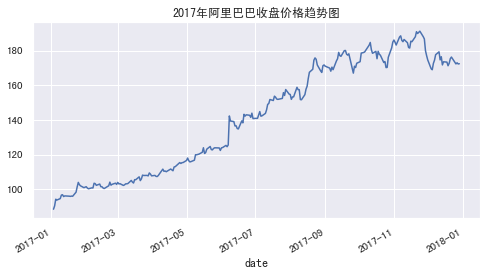

In [8]:
df_stocks[df_stocks['stock_name'] == lst_stocks[0]] \
    .loc[:, ['date', 'close']] \
    .set_index('date') \
    .plot(kind = 'line',
          figsize = (8, 4),
          legend = False,
          title = f'2017年{lst_stocks[0]}收盘价格趋势图')
plt.show()

从图中我们得到以下信息：

* 阿里巴巴股价在2017年增长迅速，从不到100涨到近180。
* 股价在2017年6月有一次快速增幅，可能是市场收到巨大利好的刺激。
* 从2017年9月开始股价波动较大，可能是前期涨幅过大，又没有其他利好导致的盘整。
* 2017年底有较大回撤。

**此外在做图时，我利用了dataframe的函数功能结合```\```进行换行，使得整体代码整洁。**

**多只股票价格折线图**

1. 展示什么：多只股票这一年的股价趋势，即股价在时间轴上的对比。
2. 数据类型：多类别非周期性数据，在不同时间点的股价。
3. 选择图表：多类别折线图。

那把多个折线图放一张图上要怎么做呢？

只要用matplotlib的subplots函数返回ax，ax可以理解为一个空坐标轴。在使用plot函数时指定ax = ax，所有的图就画在同一个坐标轴上了。

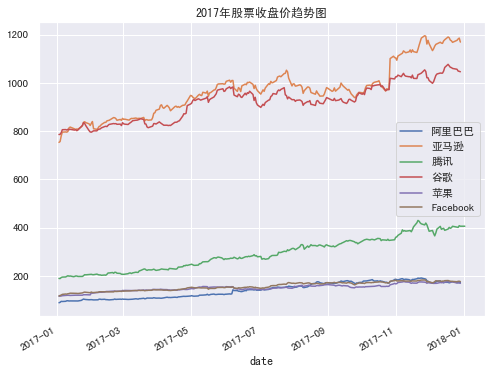

In [9]:
# 设置坐标周和图表大小。
fig, ax = plt.subplots(figsize = (8,6))
for s in lst_stocks:
    # 绘制每个股票收盘价格折线图
    df_stocks[df_stocks['stock_name'] == s] \
        .loc[:, ['date', 'close']] \
        .set_index('date') \
        .plot(kind = 'line',
              ax = ax)
# 更新图示为对应股票名
ax.legend(lst_stocks, loc = 5)
plt.title('2017年股票收盘价趋势图')
plt.show()

把多个股票价格趋势图画在同一张图上，我们的关注点是不同股票之间的对比。从上图我们可以得到一些简单的结论：

* 从图上就能直观看到亚马逊与谷歌股价波动较为明显。
* 在2017年，亚马逊与谷歌的股价较为接近。到11月份时，亚马逊的股价有一次较大涨幅。
* 其他股票股价相对亚马逊与谷歌较低，有需要可以把股价便宜的股票放在同一坐标进行比较。

**股价均线图**

1. 展示什么：一只股票这一年的股价趋势和它的均线。
2. 数据类型：多类别非周期性数据，在不同时间点的股价和移动平均值。
3. 选择图表：多类别折线图。

接下来我们利用pandas生成30, 60, 90天的移动平均值。再在收盘价趋势图上画出这3条[移动平均线](https://baike.baidu.com/item/%E7%A7%BB%E5%8A%A8%E5%B9%B3%E5%9D%87%E7%BA%BF/217887)。

In [10]:
# 计算移动平均值。
df_amzn = df_stocks[df_stocks['stock_name'] == '亚马逊'].copy()
df_amzn['thirty_ma'] = df_amzn.close.rolling(window = 30).mean()
df_amzn['sisty_ma'] = df_amzn.close.rolling(window = 60).mean()
df_amzn['ninety_ma'] = df_amzn.close.rolling(window = 90).mean()

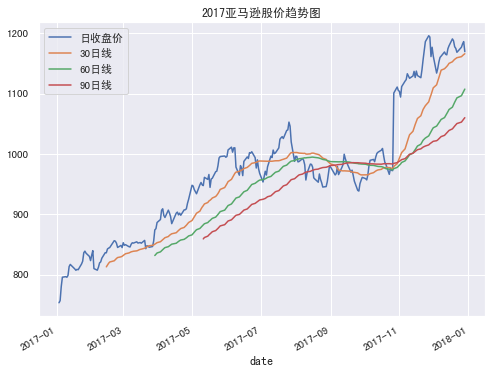

In [11]:
# 生成坐标轴并定义图表大小。
fig, ax = plt.subplots(figsize = (8,6))
# 使用循环生成４条折线
lst_col = ['close', 'thirty_ma', 'sisty_ma', 'ninety_ma']
for c in lst_col:
    df_amzn \
        .loc[:, ['date', c]] \
        .set_index('date') \
        .plot(kind = 'line',
              ax = ax,
              title = '2017亚马逊股价趋势图')
# 更新标签
lst_led = ['日收盘价', '30日线', '60日线', '90日线']
ax.legend(lst_led)
plt.show()

从上图就可以非常直观看到多条均线的走势。亚马逊在7月前都在上升通道中，股价稳定上涨。但是在7月到11月之间从3条均线都可以看到下降趋势。而在11月后三条均线都转成上市趋势。

**不同股票收盘价箱线图**

1. 展示什么：多只股票价格分布，对比波动性。
2. 数据类型：单一变量多类别。
3. 选择图表：多类别箱线图。

在前面的例子中我们使用了折线图对比了不同公司股票收盘价的趋势，但是由于不同股票的价格区间不同，想要比较他们的价格波动性，折线图显然不是最好的选择。而使用[箱线图](https://baike.baidu.com/item/%E7%AE%B1%E5%BD%A2%E5%9B%BE/10671164?fromtitle=%E7%AE%B1%E7%BA%BF%E5%9B%BE&fromid=10101649)就能很好地展现数据的分布情况。

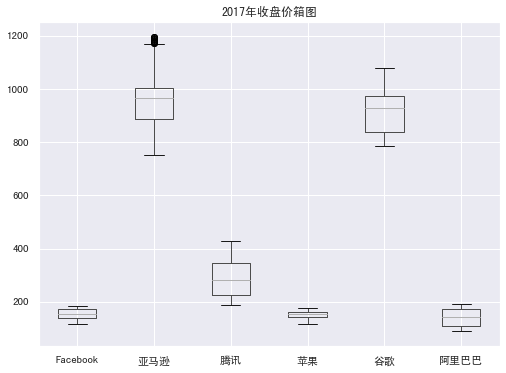

In [12]:
# 使用boxplot画出箱线图
df_stocks \
    .loc[:, ['stock_name','close']] \
    .boxplot(by = 'stock_name',
             figsize = (8,6)) \
    .set(xlabel=None)
plt.suptitle('')
plt.title('2017年收盘价箱图')
plt.show()

从箱线图中可以看到：

* 亚马逊股价波动最为明显，他与谷歌在同一价格区间，但是波动性超过了谷歌。
* Facebook和苹果的股价相对稳定。

**亚马逊月箱线图**

1. 展示什么：一只股票股价趋势，同时对比段时间(一个月内)股价波动性。
2. 数据类型：单一变量，有序类别。
3. 选择图表：多类别箱线图。

只用pandas和matplotlib不能画出专业的k线图，所以我们用箱线图仿[月k线图](https://baike.baidu.com/item/%E6%9C%88K%E7%BA%BF)来展示股价趋势和成交价格最大值和最小值。这里除了趋势之外，我们还能看到一段时间内数据的分布，使用[箱线图](https://baike.baidu.com/item/%E7%AE%B1%E5%BD%A2%E5%9B%BE/10671164?fromtitle=%E7%AE%B1%E7%BA%BF%E5%9B%BE&fromid=10101649)就可以很好地展示这些数据特征。

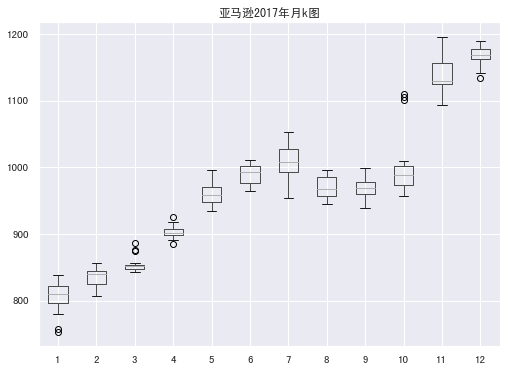

In [13]:
# 使用boxplot可以画出简单k线图
df_amzn \
    .loc[:, ['month','close']] \
    .boxplot(by = 'month',
             figsize = (8,6)) \
    .set(xlabel=None)
plt.suptitle('')
plt.title('亚马逊2017年月k图')
plt.show()

我们使用了boxplot画了一个简单的月k图，如果要画出专业的k线图需要使用```matplotlib.finance```三方包。比如下图就是用它画出来的。这里我们不再深入讨论，有兴趣的同学可以查看[官方文档](https://matplotlib.org/api/finance_api.html)，或搜索其他资料。

![plot_using_mf](https://saralgyaan.com/media/images/uploads/2019/09/08/6b24c3fd8d-candlestick_chart_in_python.png)

**亚马逊月平均成交量柱状图**

1. 展示什么：单只股票对比其不同月份的月均交易量。
2. 数据类型：单一变量，有序类别。
3. 选择图表：柱状图。

这里我们只关心每个月均量的对比，而不需要看数据分布，所以选择柱状图。

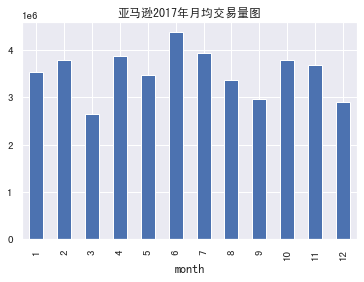

In [14]:
# 使用boxplot可以画出简单k线图
df_amzn \
    .groupby('month')['volume'] \
    .mean() \
    .plot(kind = 'bar')
plt.title('亚马逊2017年月均交易量图')
plt.show()

可以注意到亚马逊在3月和9月成交量较少，而其他月份较为平均。这与月k图对应：3月价格较为稳定，上升缓慢；而9月在8月价格下跌后，成交量减小。有些股民买在7月高点，不想亏本出售，并且价格下跌使得追高买入的人减少，这导致9月成交量相对较小。

**箱图和柱状图在同一画布**

使得报告更紧凑，或者方便从不同维度解释数据，有时候我们要把多个图表画在同一个画布上。
这里我们把之前生成的亚马逊箱线图和柱状图合并成一个图表。

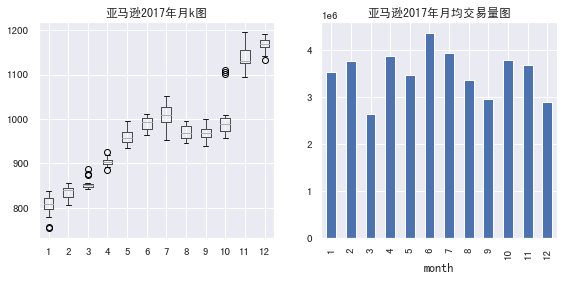

In [15]:
# 设置画布
fig, ax = plt.subplots(1,2, figsize = (9,4))

df_amzn \
    .loc[:, ['month','close']] \
    .boxplot(by = 'month',
             figsize = (8,6),
             ax = ax[0]) \
    .set(xlabel=None, title = '亚马逊2017年月k图')
plt.suptitle('')
df_amzn \
    .groupby('month')['volume'] \
    .mean() \
    .plot(kind = 'bar',
          ax = ax[1],
          title = '亚马逊2017年月均交易量图')
plt.show()

通过subplots函数设置画布后，可以指定每个图表的ax位置。比如这里ax只设置了1行2列，我不需要指定行的位置，只要指定列的位置。那```ax[0]```表示第一行、第一列的位置，同理```ax[1]```表示第一行、第二列的位置。

这样就能把不同图表整合到一个图片中，使得整体简洁，并利于从多维度展示数据信息。

**亚马逊收盘价与成交量散点图**

1. 展示什么：单只股票收盘价和成交量的关系。
2. 数据类型：2个数值变量。
3. 选择图表：散点图。

如果要对比两个变量之间的关系，则需要使用散点图。我们想要知道收盘价与成交量之间的相关度，使用[散点图](https://baike.baidu.com/item/%E6%95%A3%E7%82%B9%E5%9B%BE#:~:text=%E6%95%A3%E7%82%B9%E5%9B%BE%E6%98%AF%E6%8C%87,%E5%9B%BE%E8%A1%A8%E4%B8%AD%E7%9A%84%E4%BD%8D%E7%BD%AE%E8%A1%A8%E7%A4%BA%E3%80%82)就能很好地展示这一点。

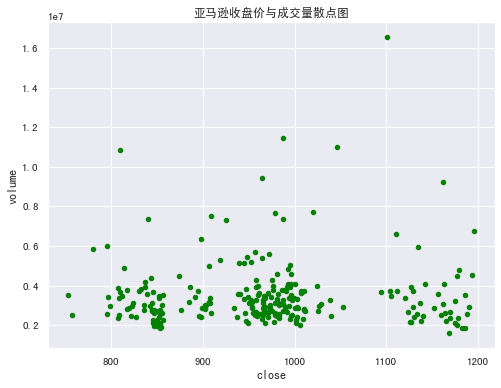

亚马逊收盘价与成交量相关矩阵


,close,volume
close,1.000000,0.044534
volume,0.044534,1.000000


In [23]:
# 散点图
df_amzn \
    .loc[:, ['close', 'volume']] \
    .plot(x = 'close', y = 'volume',
          kind = 'scatter',
          figsize = (8,6),
          color = 'green',
          title = '亚马逊收盘价与成交量散点图')
plt.show()
print('亚马逊收盘价与成交量相关矩阵')
df_amzn.loc[:, ['close', 'volume']].corr()

从相关矩阵上看，收盘价与成交量相关性小于0.05，无明显相关性。从散点图上看，成交量在不同价格区间内较为集中。

# 总结

至此，我们学习了：

* 按需求选择图表的三个步骤:1.展示什么。2.数据类型。3.选择图表。
* 利用dataframe的函数功能结合\进行换行，使得整体代码整洁。
* 如何解释图表，发现图表传递的信息。

感谢您的阅读，您的喜欢和点赞是我继续分享的动力！
这文章对应的代码可以在这里下载。